In [2]:
# ==========================================
# SETUP BLOCK - loads data, applies project helpers
# ==========================================

import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append(os.path.abspath(".."))

from Helper_functions import (
    clean_up_subjects,
    calculate_true_false_score,
    calculate_internet_terms_understanding_score,
    group_internet_understanding,
    analyze_distribution,
    analyze_subject_distribution
)

from answer_categories import COLUMN_ALIASES

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

DATA_FILE = os.path.join("..", "Data", "Fertige Tabelle.xlsx")
df = pd.read_excel(DATA_FILE)
df.columns = df.columns.astype(str).str.strip()

df = df.rename(columns=COLUMN_ALIASES)

for col in ["Most used subjects", "Preferred Subjects", "Least preferred Subjects"]:
    if col in df.columns:
        df = clean_up_subjects(df, col)

true_false_cols = [f"True/False_{i}" for i in range(1, 7)]
if all(c in df.columns for c in true_false_cols):
    df = calculate_true_false_score(df)

if any(c.startswith("Internet terms_") for c in df.columns):
    df = calculate_internet_terms_understanding_score(df)
    df = group_internet_understanding(df)

print("Setup complete – DataFrame loaded and preprocessed")
print(f"Rows: {len(df)}, Columns: {len(df.columns)}")


Setup complete – DataFrame loaded and preprocessed
Rows: 203, Columns: 43


c:\Users\tills\Bachelor-Code\Analyse_Files\Helper_functions.py:93: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_mapped = df[internet_cols].replace(Internet_terms_mapping)


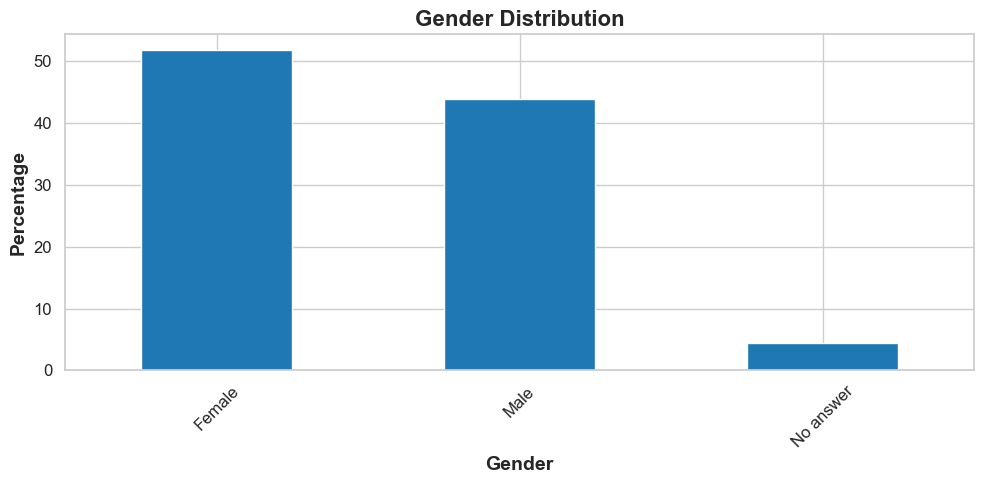


Table for: Gender Distribution
           Count  Percentage
Gender                      
Female       105        51.7
Male          89        43.8
No answer      9         4.4


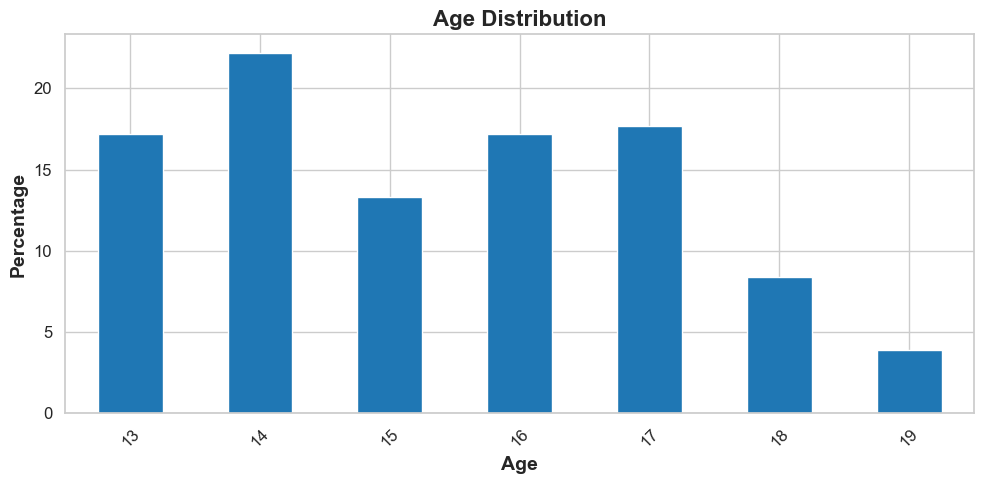


Table for: Age Distribution
     Count  Percentage
Age                   
13      35        17.2
14      45        22.2
15      27        13.3
16      35        17.2
17      36        17.7
18      17         8.4
19       8         3.9


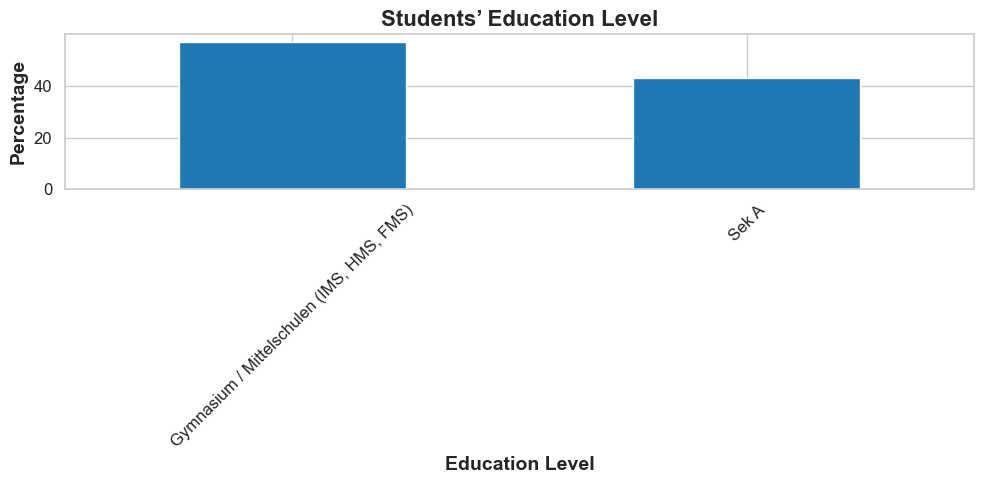


Table for: Students’ Education Level
                                           Count  Percentage
Education Level                                             
Gymnasium / Mittelschulen (IMS, HMS, FMS)    116        57.1
Sek A                                         87        42.9


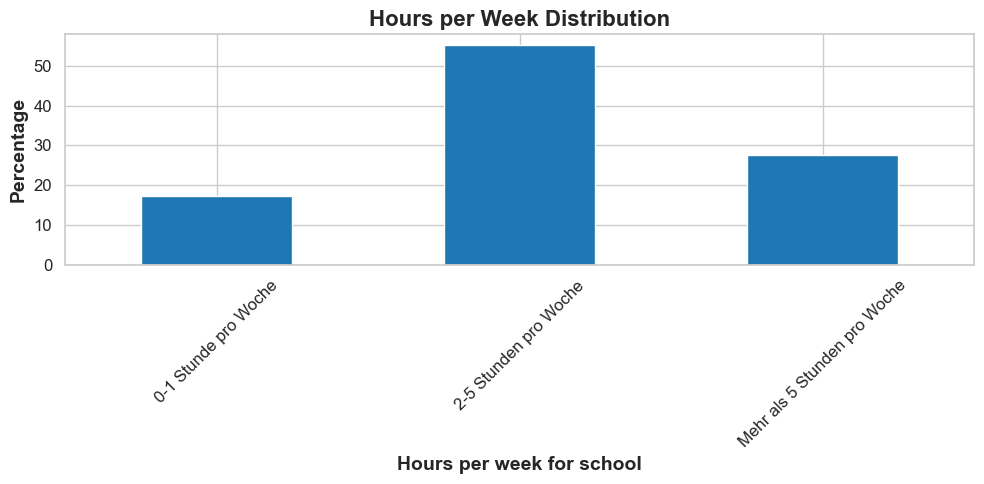


Table for: Hours per Week Distribution
                              Count  Percentage
Hours per week for school                      
0-1 Stunde pro Woche             35        17.2
2-5 Stunden pro Woche           112        55.2
Mehr als 5 Stunden pro Woche     56        27.6


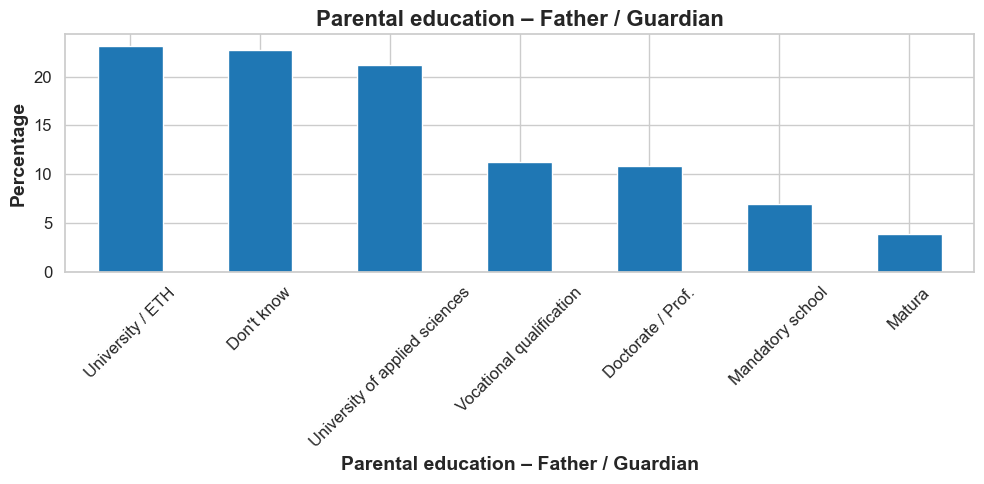


Table for: Parental education – Father / Guardian
                                Count  Percentage
Educational Level parent_1                       
University / ETH                   47        23.2
Don't know                         46        22.7
University of applied sciences     43        21.2
Vocational qualification           23        11.3
Doctorate / Prof.                  22        10.8
Mandatory school                   14         6.9
Matura                              8         3.9


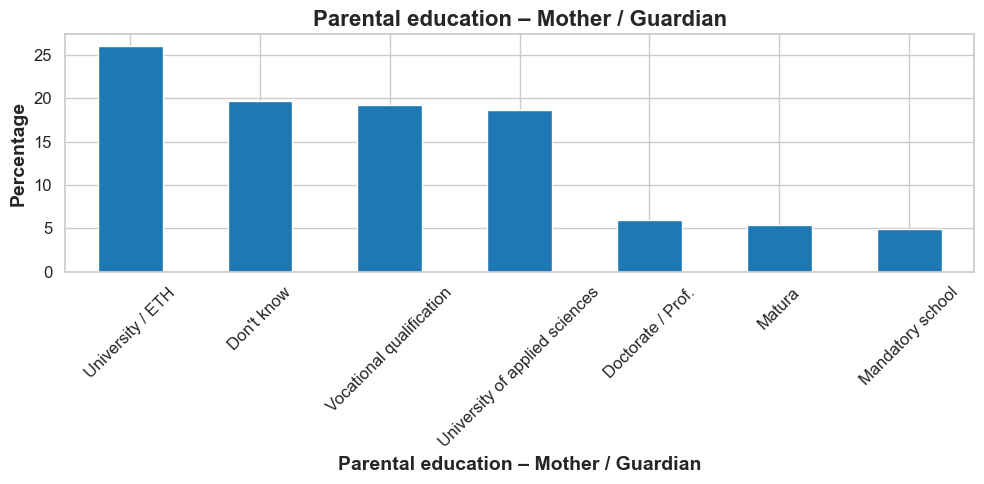


Table for: Parental education – Mother / Guardian
                                Count  Percentage
Educational Level parent_2                       
University / ETH                   53        26.1
Don't know                         40        19.7
Vocational qualification           39        19.2
University of applied sciences     38        18.7
Doctorate / Prof.                  12         5.9
Matura                             11         5.4
Mandatory school                   10         4.9


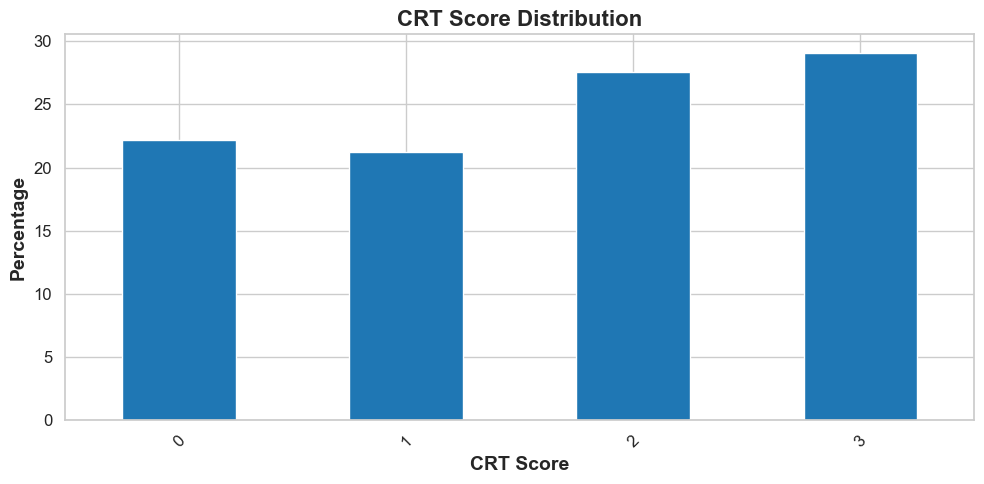


Table for: CRT Score Distribution
            Count  Percentage
CRT_points                   
0              45        22.2
1              43        21.2
2              56        27.6
3              59        29.1


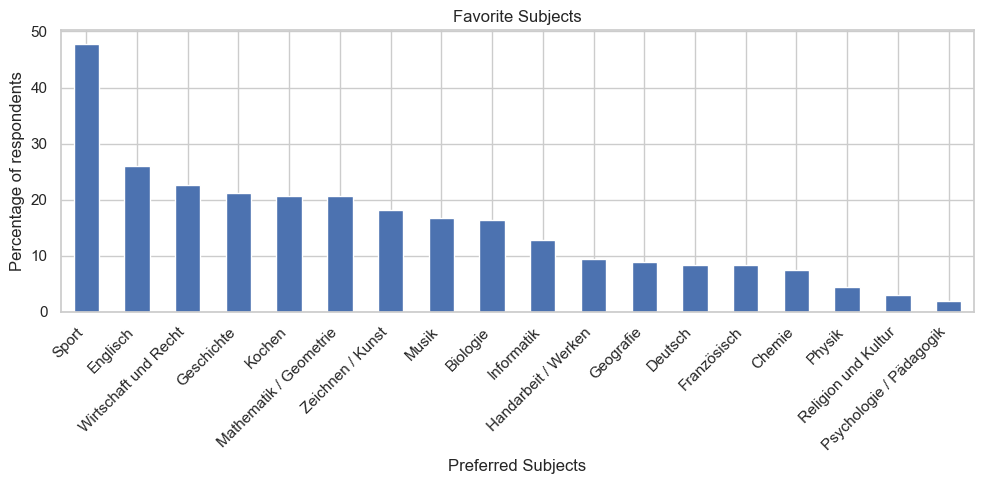


Table for: Favorite Subjects
                         Mentions  Percentage of respondents
Preferred Subjects                                          
Sport                          97                       47.8
Englisch                       53                       26.1
Wirtschaft und Recht           46                       22.7
Geschichte                     43                       21.2
Kochen                         42                       20.7
Mathematik / Geometrie         42                       20.7
Zeichnen / Kunst               37                       18.2
Musik                          34                       16.7
Biologie                       33                       16.3
Informatik                     26                       12.8
Handarbeit / Werken            19                        9.4
Geografie                      18                        8.9
Deutsch                        17                        8.4
Französisch                    17                      

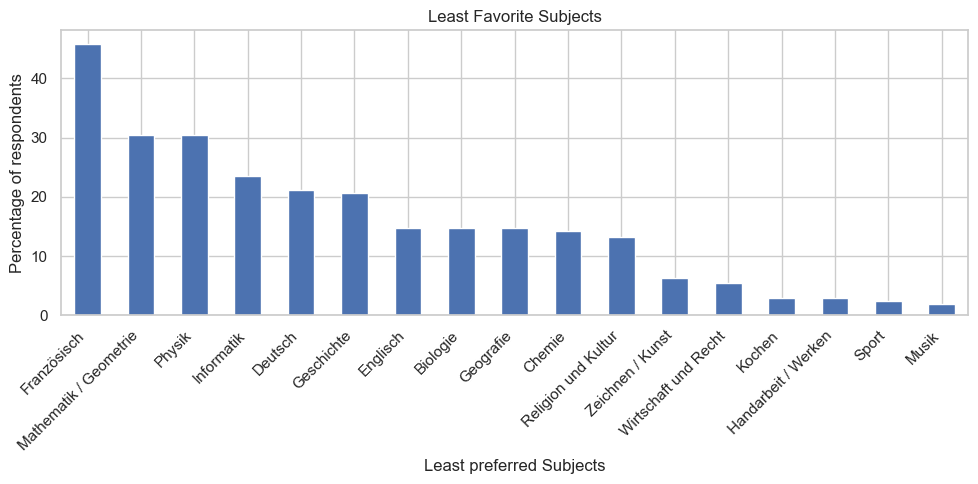


Table for: Least Favorite Subjects
                          Mentions  Percentage of respondents
Least preferred Subjects                                     
Französisch                     93                       45.8
Mathematik / Geometrie          62                       30.5
Physik                          62                       30.5
Informatik                      48                       23.6
Deutsch                         43                       21.2
Geschichte                      42                       20.7
Englisch                        30                       14.8
Biologie                        30                       14.8
Geografie                       30                       14.8
Chemie                          29                       14.3
Religion und Kultur             27                       13.3
Zeichnen / Kunst                13                        6.4
Wirtschaft und Recht            11                        5.4
Kochen                           6

In [3]:
# ------- Distribution for demographics with graphs and tables -------

def show_distribution_with_plot(df, column, title=None, color="#1f77b4", sort_values=False):
    if column not in df.columns:
        return

    result = analyze_distribution(df, column, return_df=True)
    if result is None or result.empty:
        return

    if sort_values:
        result = result.sort_values("Percentage", ascending=False)

    pretty_col = column.replace("_", " ")
    if column == "Educational Level parent_1":
        pretty_col = "Parental education – Father / Guardian"
    elif column == "Educational Level parent_2":
        pretty_col = "Parental education – Mother / Guardian"
    elif column == "CRT_points":
        pretty_col = "CRT Score"

    plot_title = title or pretty_col

    ax = result.plot(
        kind="bar",
        y="Percentage",
        legend=False,
        title=plot_title,
        color=color
    )
    ax.set_ylabel("Percentage", fontsize=14, fontweight="bold")
    ax.set_xlabel(pretty_col, fontsize=14, fontweight="bold")
    ax.set_title(plot_title, fontsize=16, fontweight="bold")
    ax.tick_params(axis="x", rotation=45, labelsize=12, width=2)
    ax.tick_params(axis="y", labelsize=12, width=2)

    plt.tight_layout()
    plt.show()

    print(f"\nTable for: {plot_title}")
    print(result.to_string())


# copy to avoid touching the original df
df_en = df.copy()

# mappings 
gender_map = {
    "Weiblich": "Female",
    "Männlich": "Male",
    "Keine Angabe": "No answer"
}

parent_level_map = {
    "Abschluss an einer Universität / ETH": "University / ETH",
    "Abschluss an einer Universität oder ETH": "University / ETH",
    "Abschluss an einer Hochschule / Fachhochschule": "University of applied sciences",
    "Abschluss an einer Fachhochschule / Hochschule": "University of applied sciences",
    "Berufsabschluss": "Vocational qualification",
    "Abschluss eines Doktorat / Professur": "Doctorate / Prof.",
    "Obligatorische Schule": "Mandatory school",
    "Matura": "Matura",
    "Ich weiss es nicht": "Don't know"
}

if "Gender" in df_en.columns:
    df_en["Gender"] = df_en["Gender"].astype("string").str.strip().replace(gender_map)

for col in ["Educational Level parent_1", "Educational Level parent_2"]:
    if col in df_en.columns:
        df_en[col] = df_en[col].astype("string").str.strip().replace(parent_level_map)

# apply mappings
if "Gender" in df_en.columns:
    df_en["Gender"] = df_en["Gender"].astype(str).str.strip().replace(gender_map)

for col in ["Educational Level parent_1", "Educational Level parent_2"]:
    if col in df_en.columns:
        df_en[col] = df_en[col].astype(str).str.strip().replace(parent_level_map)

# demographic analysis

show_distribution_with_plot(df_en, "Gender", "Gender Distribution")
show_distribution_with_plot(df, "Age", "Age Distribution")
show_distribution_with_plot(df, "Education Level", "Students’ Education Level")
show_distribution_with_plot(df, "Hours per week for school", "Hours per Week Distribution")

show_distribution_with_plot(df_en, "Educational Level parent_1", sort_values=True)
show_distribution_with_plot(df_en, "Educational Level parent_2", sort_values=True)

show_distribution_with_plot(df, "CRT_points", "CRT Score Distribution")

# ---- Subject Preferences ----

def show_subject_distribution_with_plot(df, column, title=None):
    if column not in df.columns:
        return

    result = analyze_subject_distribution(df, column, return_df=True)
    if result is None or result.empty:
        return

    plot_title = title or column
    result.plot(kind="bar", y="Percentage of respondents", legend=False, title=plot_title)
    plt.ylabel("Percentage of respondents")
    plt.xlabel(column)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    print(f"\nTable for: {plot_title}")
    print(result.to_string())

show_subject_distribution_with_plot(df, "Preferred Subjects", "Favorite Subjects")
show_subject_distribution_with_plot(df, "Least preferred Subjects", "Least Favorite Subjects")
